# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/neural_network"

/content/drive/MyDrive/neural_network


In [ ]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [3]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


### 1.1 Loading the dataset

In [4]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [5]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class Segnet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    vg = models.vgg16(pretrained=True)
    self.features = vg.features
    f1= nn.Conv2d(512,4096,3)
    f2= nn.Conv2d(4096,4096,1)
    self.layer= nn.Sequential(f1, nn.ReLU(inplace= True), nn.Dropout(), f2, nn.ReLU(inplace= True),nn.Dropout())


    score_32s = nn.Conv2d(4096, num_classes, 1)
    self._normal_initialization(score_32s)
    self.score_32s = score_32s
  
  def _normal_initialization(self, layer):
    layer.weight.data.normal_(0, 0.01)
    layer.bias.data.zero_()
    
  def forward(self, x):
    #define the forward pass
    input_spatial_dim = x.size()[2:]
    f= self.features(x)
    l = self.layer(f)
    x = self.score_32s(l)
    x_out = F.upsample_bilinear(input=x, size=input_spatial_dim)
    
    return x_out
        
    

       

    

In [6]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
model = Segnet(21)
model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Segnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 5
epochs = 20

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [7]:
# dataset variable
dst = pascalVOCDataset('VOCdevkit/VOC2012/', is_transform= True)

# dataloader variable
trainloader = torch.utils.data.DataLoader(dst, bs, shuffle=True)

  0%|          | 0/2913 [00:00<?, ?it/s]

Pre-encoding segmentation masks...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:220: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:221: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
100%|██████████| 2913/2913 [37:34<00:00,  1.29it/s]


In [ ]:
model = Segnet(21)
model.load_state_dict(torch.load('epoch-19.pt'))
model.eval()
model.cuda()

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [9]:
import torch.optim as optim
# loss function
loss_f = nn.CrossEntropyLoss().cuda()

# optimizer variable
opt = optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.0005)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [10]:
for e in range(epochs):
  for i, d in enumerate(trainloader):
    # your code goes here
    image,label= d
    image=image.cuda()
    label=label.cuda()
    prediction= model.forward(image)
    loss= loss_f(prediction,label)
    loss.backward()
    opt.step()
    if i % 10 == 0:
      print("epoch{}, iter{}, loss: {}".format(e,i,loss.data))
  torch.save(model.state_dict(), 'epoch-{}.pt'.format(e))

path= " "
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3669: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


epoch0, iter0, loss: 3.0802764892578125
epoch0, iter10, loss: 2.974135160446167
epoch0, iter20, loss: 2.8564019203186035
epoch0, iter30, loss: 2.6230721473693848
epoch0, iter40, loss: 2.5841734409332275
epoch0, iter50, loss: 2.34382963180542
epoch0, iter60, loss: 2.208967685699463
epoch0, iter70, loss: 1.7178795337677002
epoch0, iter80, loss: 2.351370096206665
epoch0, iter90, loss: 1.5708281993865967
epoch0, iter100, loss: 1.8883718252182007
epoch0, iter110, loss: 2.351616382598877
epoch0, iter120, loss: 2.490950107574463
epoch0, iter130, loss: 0.7914124131202698
epoch0, iter140, loss: 1.8019895553588867
epoch0, iter150, loss: 2.0056326389312744
epoch0, iter160, loss: 1.5425620079040527
epoch0, iter170, loss: 1.298337697982788
epoch0, iter180, loss: 1.540027379989624
epoch0, iter190, loss: 1.5879504680633545
epoch0, iter200, loss: 1.6894506216049194
epoch0, iter210, loss: 1.9175153970718384
epoch0, iter220, loss: 1.4051036834716797
epoch0, iter230, loss: 1.2662622928619385
epoch0, iter

In [11]:
torch.save(model,'train_model')

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [20]:
from sklearn import metrics

def evaluate(ground_truth, predictions):
  f1_score = metrics.f1_score(ground_truth.cuda().detach().cpu().numpy().reshape(-1), predictions.cuda().detach().cpu().numpy().argmax(1).reshape(-1), average= 'micro')
  jac_score = metrics.jaccard_score(ground_truth.cuda().detach().cpu().numpy().reshape(-1), predictions.cuda().detach().cpu().numpy().argmax(1).reshape(-1), average= 'micro')
    
  return f1_score, jac_score 

In [21]:
f1_score,jac_score  = evaluate(label, prediction)
print(f1_score,jac_score)

0.8361129760742188 0.718379841759913


In [9]:
tmodel= torch.load('train_model')
tmodel.eval()

Segnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [25]:
t_f1=0
t_ja=0
counter=0
f1=[]
j1=[]
epoch=10
for e in range(epoch):
  for i, d in enumerate(trainloader):
    # your code goes here
    image,label= d
    image=image.cuda()
    label=label.cuda()
    pred= tmodel(image)
    loss= loss_f(pred,label)
    a,b= evaluate(label,pred)
    t_f1=t_f1+a
    t_ja=t_ja+b
    counter=counter+1
    if i % 10 == 0:
      print("epoch{}, iter{}, loss: {}".format(e,i,loss.data))

  f1.append(t_f1/counter)
  j1.append(t_ja/counter)




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3669: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


epoch0, iter0, loss: 0.9705570340156555
epoch0, iter10, loss: 0.5687035322189331
epoch0, iter20, loss: 0.4321663975715637
epoch0, iter30, loss: 0.5965954065322876
epoch0, iter40, loss: 0.5609354376792908
epoch0, iter50, loss: 0.723423421382904
epoch0, iter60, loss: 0.8018849492073059
epoch0, iter70, loss: 0.43746423721313477
epoch0, iter80, loss: 0.2905302345752716
epoch0, iter90, loss: 0.4905673861503601
epoch0, iter100, loss: 0.6266842484474182
epoch0, iter110, loss: 0.891036331653595
epoch0, iter120, loss: 1.25601065158844
epoch0, iter130, loss: 0.5855782628059387
epoch0, iter140, loss: 1.0393874645233154
epoch0, iter150, loss: 0.6283247470855713
epoch0, iter160, loss: 1.0107359886169434
epoch0, iter170, loss: 0.6382418870925903
epoch0, iter180, loss: 0.4380192160606384
epoch0, iter190, loss: 0.6578343510627747
epoch0, iter200, loss: 0.5776144862174988
epoch0, iter210, loss: 0.3867420256137848
epoch0, iter220, loss: 0.5598917603492737
epoch0, iter230, loss: 0.7586221694946289
epoch0

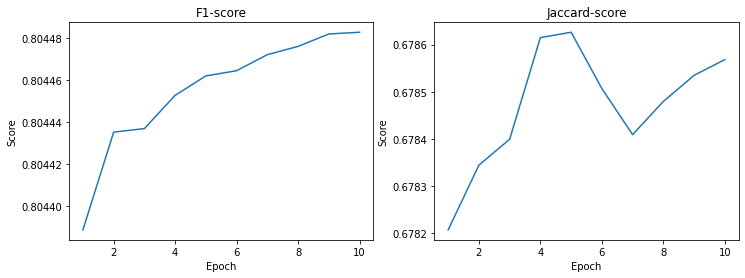

In [26]:
titles = ['F1-score','Jaccard-score']
fig,ax= plt.subplots(nrows=1, ncols=2, figsize=(12,4))
met= [f1, j1]
ep=[1,2,3,4,5,6,7,8,9,10]
for i,j in enumerate(ax.flatten()):
  plt.sca(j)
  plt.title(titles[i])
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.plot(ep,met[i])

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3669: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


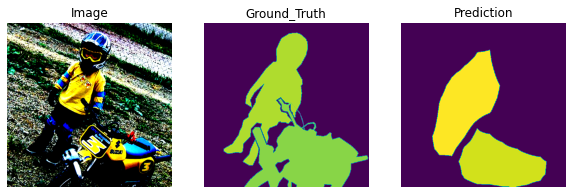

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


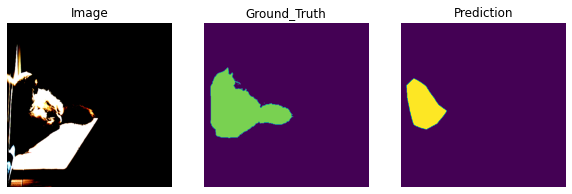

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


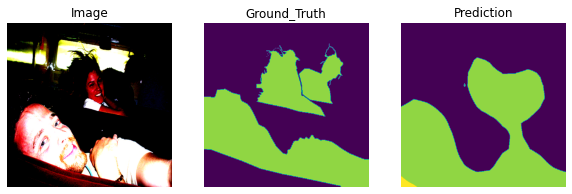

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


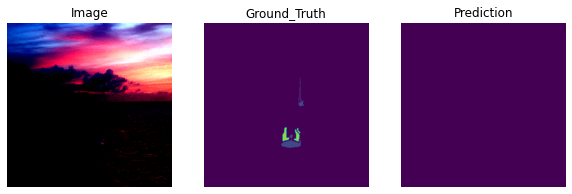

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


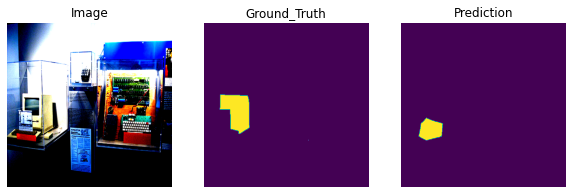

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


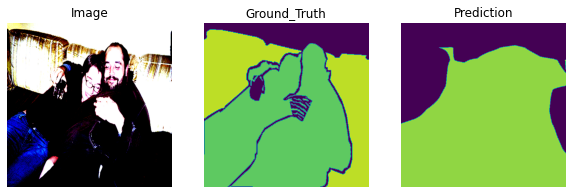

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


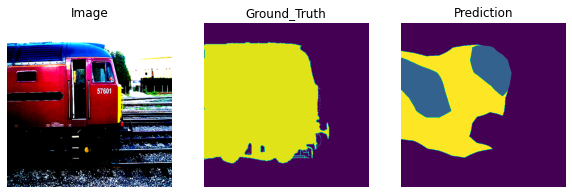

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


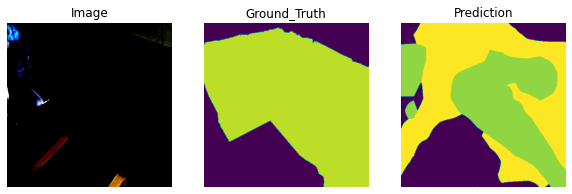

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


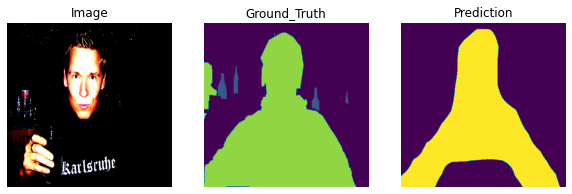

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


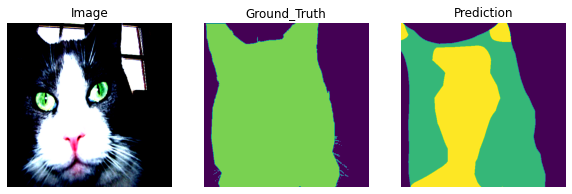

In [125]:
torch.manual_seed(10)
val= iter(trainloader)
for _ in range(10):
  fig= plt.figure(figsize=(10,10))
  image,mask= next(val)
  image= image.cuda()
  mask= mask.cuda().detach().cpu().numpy()
  preds= tmodel(image)
  preds= preds.detach().cpu().numpy()
  image= image.cpu()
  fig1= fig.add_subplot(131)
  plt.imshow(image[0].transpose(0,2).transpose(0,1).numpy())
  fig1.title.set_text("Image")
  fig1.axis("off")
  fig2= fig.add_subplot(132)
  plt.imshow(mask[0])
  fig2.title.set_text("Ground_Truth")
  fig2.axis("off")
  fig3= fig.add_subplot(133)
  plt.imshow(preds.argmax(1)[0])
  fig3.title.set_text("Prediction")
  fig3.axis("off")
  plt.show()


